In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import layoutparser as lp
import os
os.chdir('..')

In [4]:
annotated = {}
output = Path('outputs_kappa')
for i in output.glob('*_data.csv'):
    l = i.stem.split('.')
    arxiv_id = l[0]+'.'+l[1][:-2]
    annotated[arxiv_id] = i

collect = {}
docbank = Path('DocBank_500K_txt')
for i in docbank.glob('*.txt'):
    arxiv_id = str(i.stem).split('_')[1][:-3]
    page_num = int(str(i.stem).split('_')[-1]) + 1
    if arxiv_id in annotated:
        df = pd.read_csv(i, sep='\t', names=['token', 'x0', 'y0', 'x1', 'y1', 'r', 'g', 'b', 'fontname', 'label'])
        if arxiv_id in collect:
            collect[arxiv_id].append((page_num, df))
        else:
            collect[arxiv_id] = [(page_num, df)]
print(len(collect.keys()))
pred = []
gold = []
for k, v in collect.items():
    rainbow = pd.read_csv(annotated[k], sep='\t')
    for page, df in v:
        print(k, page)
        filtered = rainbow[rainbow['page']==page]
        layout = {}
        for idx, row in df.iterrows():
            layout[row['token']] = row['label']
        for idx, row in filtered.iterrows():
            label = row['label']
            if isinstance(label, str):
                label = label.lower()
            else:
                label = 'none'
            if row['token'] in layout:
                gold.append(layout[row['token']])
                pred.append(label)
                print(layout[row['token']], label)
        #print(layout)

51
1801.02026 5
paragraph none
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equation
equation equati

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(pred+gold)

import sklearn.metrics
sklearn.metrics.cohen_kappa_score(le.transform(gold), le.transform(pred))

0.2893442387573929

In [6]:
le.classes_

array(['abstract', 'author', 'caption', 'date', 'equation', 'figure',
       'footer', 'list', 'none', 'paragraph', 'reference', 'section',
       'table', 'title'], dtype='<U9')

In [7]:
sklearn.metrics.precision_score(le.transform(gold), le.transform(pred), average=None)

/home/duan/texcompile/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.77651822, 0.31205674, 0.31190203, 0.        , 0.19943851,
       0.        , 0.38475177, 0.32418813, 0.        , 0.90993576,
       0.77808917, 0.38681319, 0.81490385, 0.12380952])

In [8]:
sklearn.metrics.recall_score(le.transform(gold), le.transform(pred), average=None)

/home/duan/texcompile/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.89458955, 0.47826087, 0.509375  , 0.        , 0.90297005,
       0.        , 0.0922619 , 0.18457125, 0.        , 0.60839348,
       0.90515708, 0.35699797, 0.82582217, 1.        ])

In [9]:
sklearn.metrics.f1_score(le.transform(gold), le.transform(pred), average=None)

array([0.83138275, 0.3776824 , 0.3868977 , 0.        , 0.32671554,
       0.        , 0.14883402, 0.23522243, 0.        , 0.72922127,
       0.83682696, 0.37130802, 0.82032668, 0.22033898])

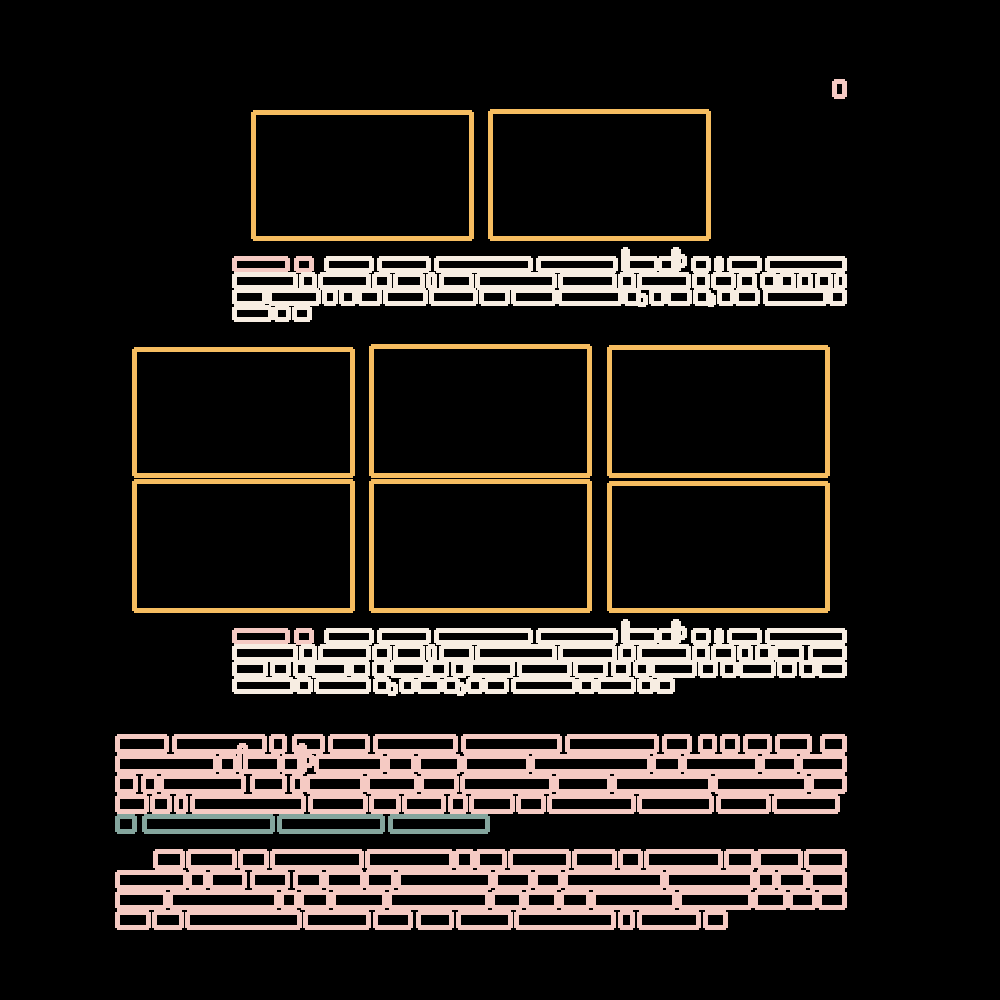

In [10]:
layout = lp.Layout()
for idx, row in df.iterrows():
    #print(row)
    layout.append(
        lp.TextBlock(
            block = lp.Rectangle(row['x0'], row['y0'], row['x1'], row['y1']),
            type  = row['label'],
        )
    )
image = np.zeros([1000,1000,3], np.uint8)
viz = lp.draw_box(image, layout)
viz

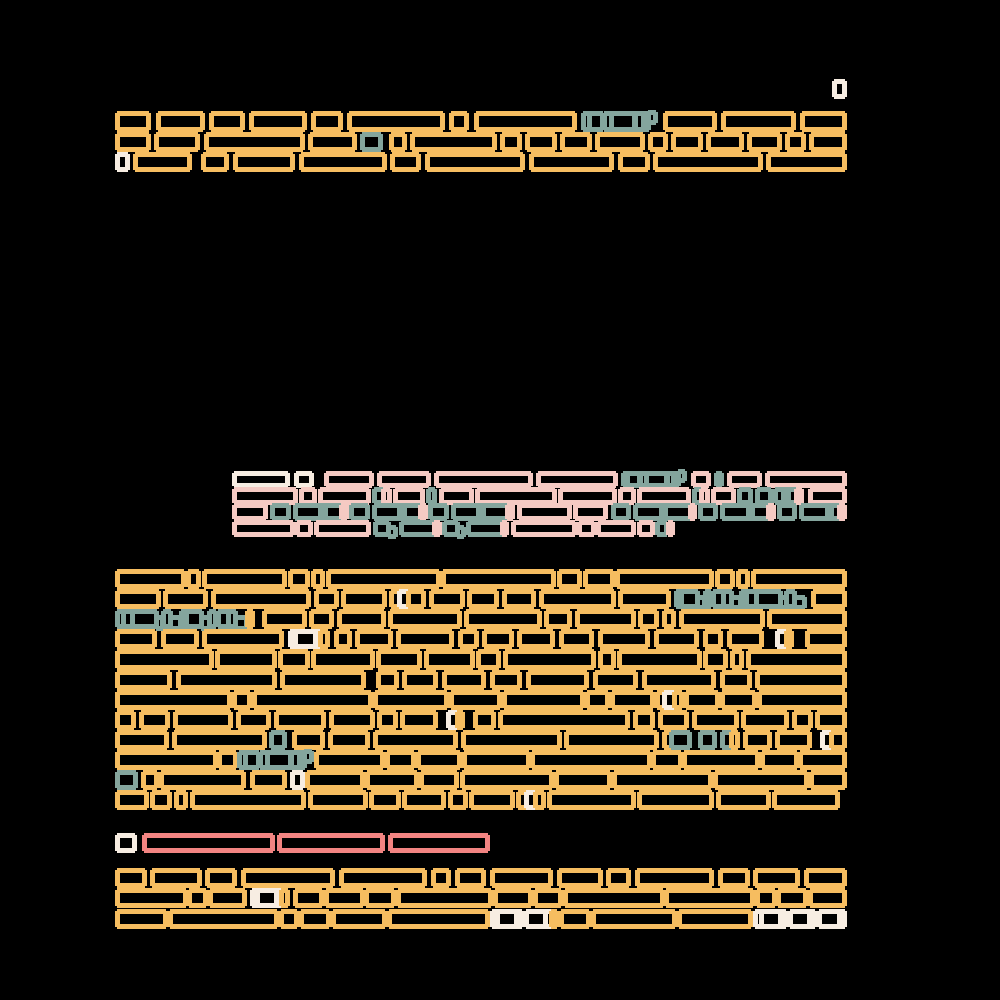

In [14]:
import json
layout2 = lp.Layout()
for i, row in filtered.iterrows():
    height, width = json.loads(row['flags'])
    f_x0 = min(1000, max(0, int(row['x0'] / width * 1000)))
    f_y0 = min(1000, max(0, int(row['y0'] / height * 1000)))
    f_x1 = min(1000, max(0, int(row['x1'] / width * 1000)))
    f_y1 = min(1000, max(0, int(row['y1'] / height * 1000)))
    word_bbox = tuple([f_x0, f_y0, f_x1, f_y1])
    
    # plot annotation
    x0, y0, x1, y1 = word_bbox
    #x0, y0, x1, y1 = int(x0 * width / 1000), int(y0 * height / 1000), int(x1 * width / 1000), int(
    #    y1 * height / 1000)
    label = row['label']
    if isinstance(label, str):
        label = label.lower()
    else:
        label = 'none'
    layout2.append(
        lp.TextBlock(
            block = lp.Rectangle(x0, y0, x1, y1),
            type  = label,
        )
    )

image2 = np.zeros([1000,1000,3], np.uint8)
viz2 = lp.draw_box(image2, layout2)
viz2